In [14]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import xlrd
import geopandas as gpd

In [15]:
RESOURCE_MAX = .5
INDICATORS = {
    'overall':{
        'crit':{
            'antimony':  {'vmax':RESOURCE_MAX},
            'beryllium': {'vmax':RESOURCE_MAX},
            'bismuth':   {'vmax':RESOURCE_MAX},
            'cadmium':   {'vmax':RESOURCE_MAX},
            'chromium':  {'vmax':RESOURCE_MAX},
            'cobalt':    {'vmax':RESOURCE_MAX},
            'graphite':  {'vmax':RESOURCE_MAX},
            'lithium':   {'vmax':RESOURCE_MAX},
            'magnesium': {'vmax':RESOURCE_MAX},
            'manganese': {'vmax':RESOURCE_MAX},
            'molybdenum':{'vmax':RESOURCE_MAX},
            'niobium':   {'vmax':RESOURCE_MAX},
            'palladium': {'vmax':RESOURCE_MAX},
            'platinum':  {'vmax':RESOURCE_MAX},
            'ree':       {'vmax':RESOURCE_MAX},
            'rhodium':   {'vmax':RESOURCE_MAX},
            'titanium':  {'vmax':RESOURCE_MAX},
            'tungsten':  {'vmax':RESOURCE_MAX},
            'uranium':   {'vmax':RESOURCE_MAX},
            'zirconium': {'vmax':RESOURCE_MAX},
        },
        'metals':{
            'aluminum':  {'vmax':RESOURCE_MAX},
            'copper':    {'vmax':RESOURCE_MAX},
            'gold':      {'vmax':RESOURCE_MAX},
            'silver':    {'vmax':RESOURCE_MAX},
            'nickel':    {'vmax':RESOURCE_MAX},
            'zinc':      {'vmax':RESOURCE_MAX},
            'lead':      {'vmax':RESOURCE_MAX},
            'steel':     {'vmax':RESOURCE_MAX},
            'tin':       {'vmax':RESOURCE_MAX},
        },
        'ag':{
            'coffee':    {'vmax':RESOURCE_MAX},
            'maize':     {'vmax':RESOURCE_MAX},
            'milk':      {'vmax':RESOURCE_MAX},
            'palm':      {'vmax':RESOURCE_MAX},
            'pork':      {'vmax':RESOURCE_MAX},
            'poultry':   {'vmax':RESOURCE_MAX},
            'rice':      {'vmax':RESOURCE_MAX},
            'soy':       {'vmax':RESOURCE_MAX},
            'sugar':     {'vmax':RESOURCE_MAX},
            'wheat':     {'vmax':RESOURCE_MAX},
            'beef':      {'vmax':RESOURCE_MAX},
        },
        'energy':{
            'gas':       {'vmax':RESOURCE_MAX},
            'oil':       {'vmax':RESOURCE_MAX},
            'coal':      {'vmax':RESOURCE_MAX},
        },
        'mil_ex': {'log':True, 'winsor':2.5},
        'arms': {
             'arms_ex': {'vmax':.5},
             'arms_im': {'vmax':.2},
        },
        'unga': {},
        'aid': {'vmax':.1},
        'trade':{'log':True, 'winsor':2.5},
        'fdi':{'log':True, 'winsor':2.5},
        'students':{
            'student_in':{'log':True, 'winsor':2.5},
            'student_out':{'log':True, 'winsor':2.5},
        }
    },
    'resources':{
        'crit',
        'metals',
        'ag',
        'energy',
    },
    'mil':{
        'arms',
        'mil_ex',
    },
    'diplo':{
        'unga',
        'aid',
    },
    'soft':{
        'trade',
        'fdi',
        'students'
    }
}
def iterind(f, indicators=None, **kwargs):
    if indicators is None:
        indicators = INDICATORS
    for k,v in indicators.items():
        if (type(v) is dict and len(v) and not ('vmin' in v or 'vmax' in v or 'log' in v)):
            iterind(f, v, **kwargs)
        f(k, v, **kwargs)

In [16]:
countries = pd.read_csv('countries.csv')
countries = countries.set_index('iso_a3').drop('-99')
#shps = gpd.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
shps = gpd.read_file('https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip')
shps.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,Fiji,FJI,...,피지,Fiji,Fidżi,Fiji,Фиджи,Fiji,Fiji,Fiji,斐濟,"(POLYGON ((180 -16.06713266364245, 180 -16.555..."
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,United Republic of Tanzania,TZA,...,탄자니아,Tanzania,Tanzania,Tanzânia,Танзания,Tanzania,Tanzanya,Tanzania,坦桑尼亚,POLYGON ((33.90371119710453 -0.950000000000000...
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,Western Sahara,SAH,...,서사하라,Westelijke Sahara,Sahara Zachodnia,Saara Ocidental,Западная Сахара,Västsahara,Batı Sahra,Tây Sahara,西撒哈拉,POLYGON ((-8.665589565454809 27.65642588959236...
3,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,Canada,CAN,...,캐나다,Canada,Kanada,Canadá,Канада,Kanada,Kanada,Canada,加拿大,"(POLYGON ((-122.84 49.00000000000011, -122.974..."
4,Admin-0 country,1,2,United States of America,US1,1,2,Country,United States of America,USA,...,미국,Verenigde Staten van Amerika,Stany Zjednoczone,Estados Unidos,Соединённые Штаты Америки,USA,Amerika Birleşik Devletleri,Hoa Kỳ,美国,"(POLYGON ((-122.84 49.00000000000011, -120 49...."


In [17]:
dat = pd.read_csv('all_ind2.csv')
dat.set_index('iso', inplace=True)
dat['fdi_us'].loc[dat['fdi_us']==0] = np.nan
dat['fdi_cn'].loc[dat['fdi_cn']==0] = np.nan
dat['country'] = countries['name']
dat = dat[countries['primary']>0]
us_col = [c for c in dat if c[-2:]=='us']
cn_col = [c for c in dat if c[-2:]=='cn']
dat.at['USA', us_col] = np.nan
dat.at['CHN', cn_col] = np.nan
dat.loc[['USA', 'CHN']]


/usr/local/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,country,aluminum_us,aluminum_cn,antimony_us,antimony_cn,beryllium_us,beryllium_cn,bismuth_us,bismuth_cn,cadmium_us,...,aid_us,aid_cn,unga_us,unga_cn,arms_ex_us,arms_im_us,arms_ex_cn,arms_im_cn,mil_ex_us,mil_ex_cn
iso,,,,,,,,,,,,,,,,,,,,,
USA,United States of America,NaN,0.0,NaN,0.001,NaN,0.051,NaN,0.002,NaN,...,NaN,0.0,NaN,0.18,NaN,NaN,0.0,0.0,NaN,23.0
CHN,China,0.001,NaN,0.524,NaN,0.0,NaN,0.752,NaN,0.046,...,0.0,NaN,0.18,NaN,0.0,0.0,NaN,NaN,7.0,NaN


In [18]:
def norm(seq, vmin=None, vmax=None, log=False, winsor=False):
    if log:
        seq = seq+1
    if not vmin:
        if winsor:
            vmin = np.nanpercentile(seq, winsor)
        else:
            vmin = np.min(seq)
    if not vmax:
        if winsor:
            vmax = np.nanpercentile(seq, 100-winsor)
        else:
            vmax = np.max(seq)
    if log:
        seq = np.log(seq)
        vmin = np.log(vmin)
        vmax = np.log(vmax)
    s = (seq - vmin)/(vmax - vmin)
    s = np.clip(s, 0, 1)
    return s

In [19]:
out = pd.DataFrame(index=dat.index)
out['country'] = dat['country']

def agg(ind, args, df=out, max_resources=False):
    usi = '{}_us'.format(ind)
    cni = '{}_cn'.format(ind)
    if args == {} or 'vmin' in args or 'vmax' in args or 'log' in args:
        if usi in dat:
            if not 'vmax' in args:
                if 'winsor' in args:
                    args['vmax'] = np.nanpercentile(np.vstack((dat[usi], dat[cni])), 100-args['winsor'])
                else:
                    args['vmax'] = np.nanmax(np.vstack((dat[usi], dat[cni])))
            df[usi] = norm(dat[usi], **args)
            df.at['USA', usi] = np.nan
            df[cni] = norm(dat[cni], **args)
            df.at['CHN', cni] = np.nan
    else:
        usargs = ['{}_us'.format(arg) for arg in args]
        cnargs = ['{}_cn'.format(arg) for arg in args]
        df[usi] = np.nanmean(df[usargs], axis=1)
        df[cni] = np.nanmean(df[cnargs], axis=1)
        vmax = np.nanmax(np.vstack((df[usi], df[cni])))
        df[usi] = df[usi]/vmax
        df[cni] = df[cni]/vmax

out2 = out.copy()
iterind(agg, df=out)

out.head()

/usr/local/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/usr/local/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


,country,antimony_us,antimony_cn,beryllium_us,beryllium_cn,bismuth_us,bismuth_cn,cadmium_us,cadmium_cn,chromium_us,...,overall_us,overall_cn,resources_us,resources_cn,mil_us,mil_cn,diplo_us,diplo_cn,soft_us,soft_cn
iso,,,,,,,,,,,,,,,,,,,,,
AFG,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.345749,0.164688,0.000000,0.000000,0.313333,0.000000,0.626667,0.493769,0.406432,0.139877
AGO,Angola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.212689,0.397177,0.024199,0.211071,0.203255,0.207742,0.063762,0.544070,0.513550,0.429960
ALB,Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006,...,0.246478,0.113487,0.000519,0.006577,0.351573,0.000000,0.297954,0.244251,0.310116,0.184500
ARE,United Arab Emirates,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002,...,0.452299,0.319802,0.015944,0.055506,0.739843,0.006667,0.091881,0.457971,0.707867,0.535387
ARG,Argentina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.422065,0.301803,0.068328,0.074987,0.536588,0.000000,0.151881,0.453239,0.667484,0.475843


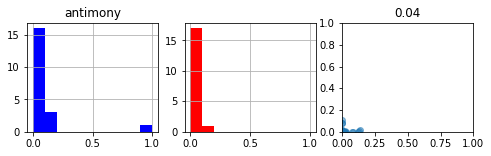

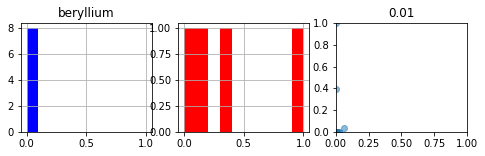

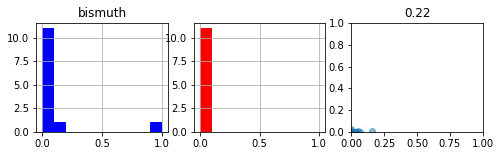

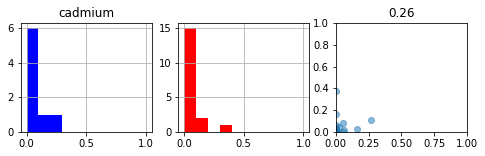

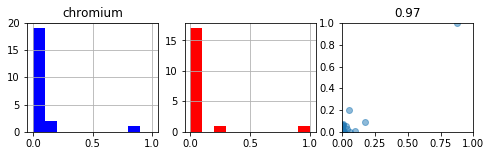

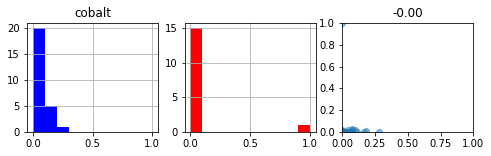

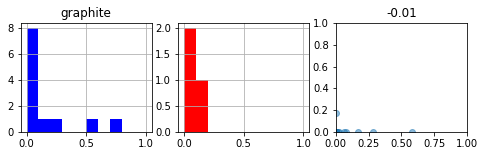

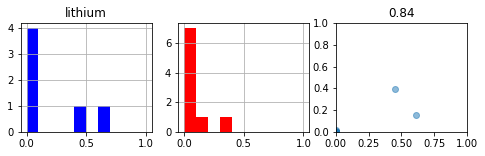

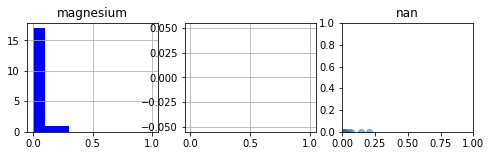

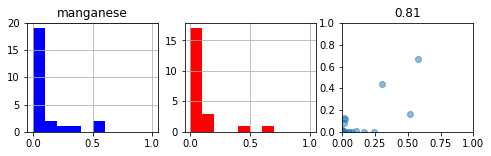

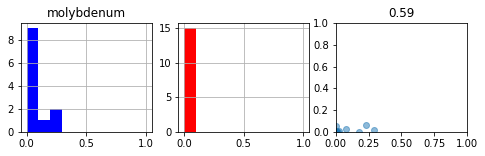

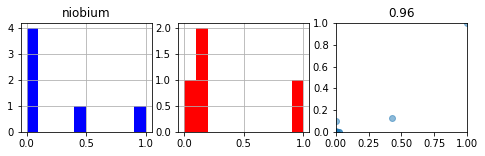

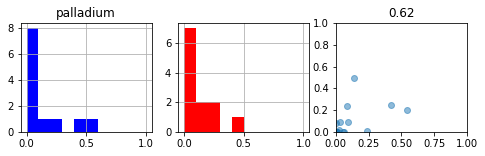

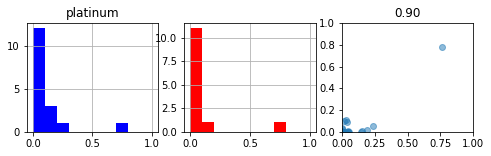

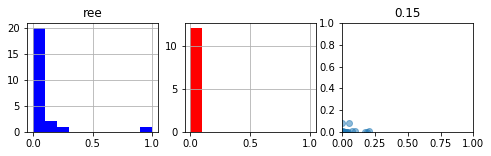

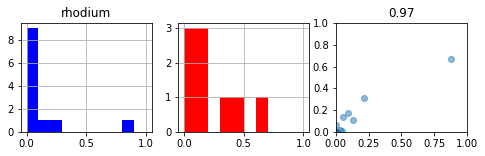

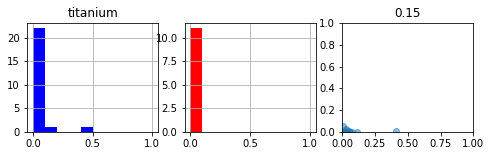

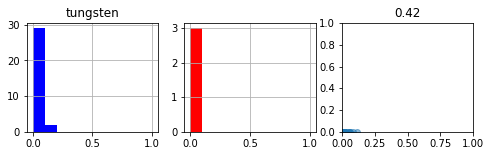

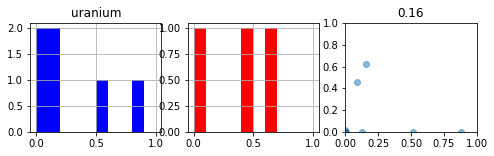

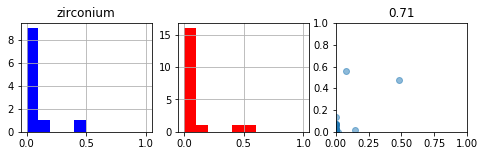

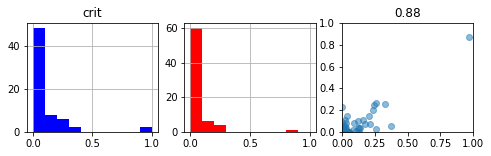

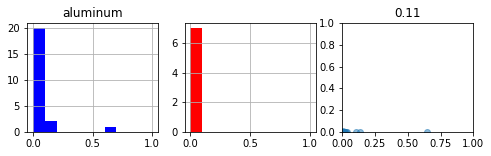

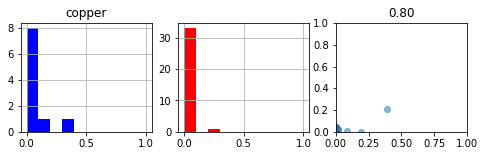

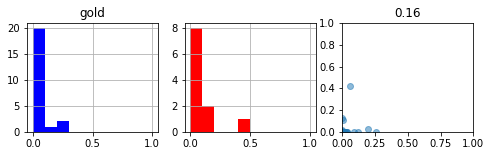

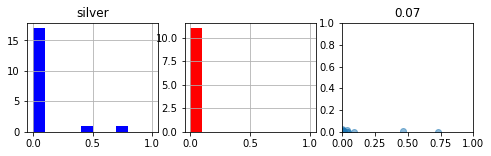

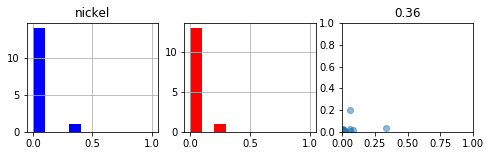

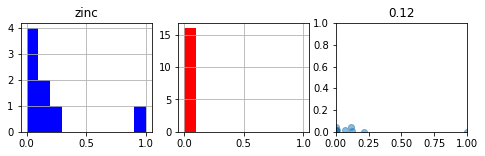

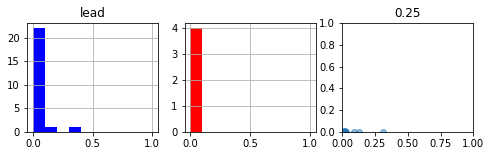

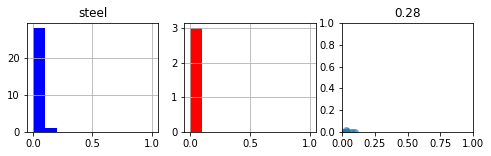

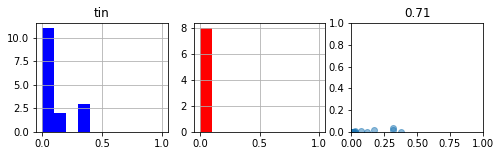

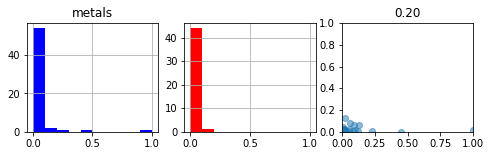

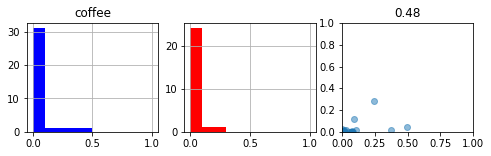

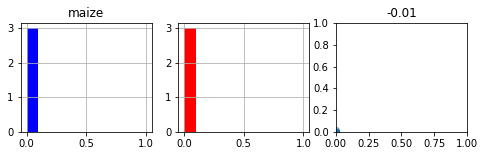

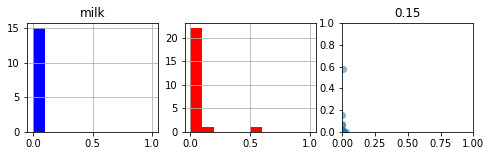

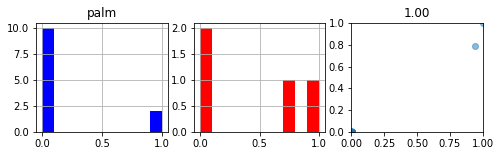

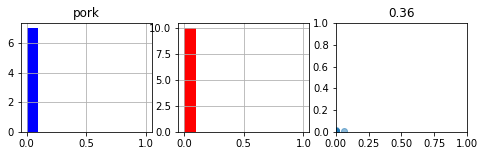

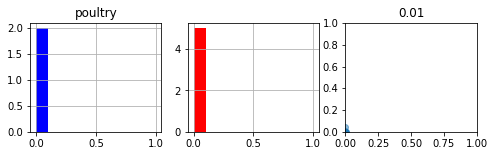

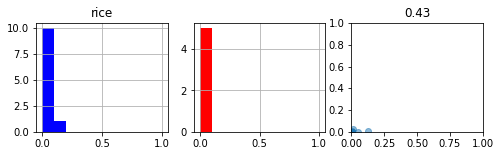

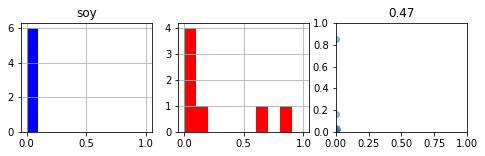

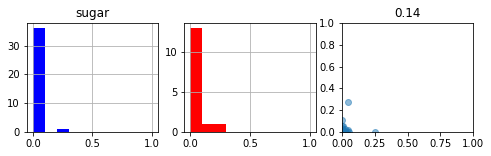

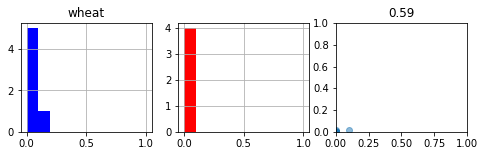

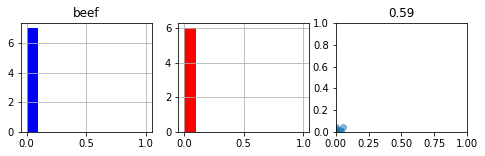

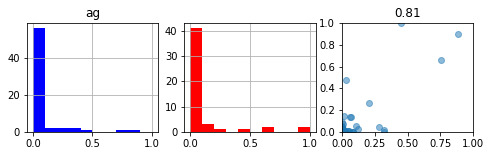

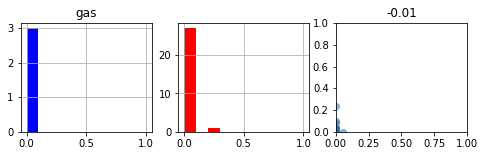

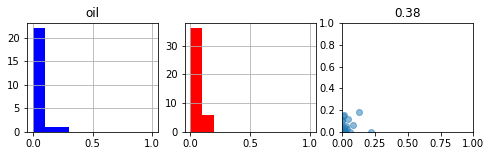

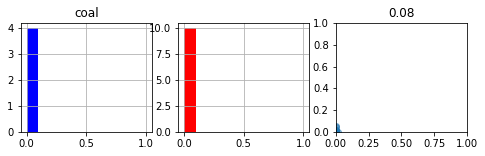

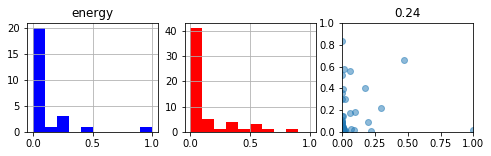

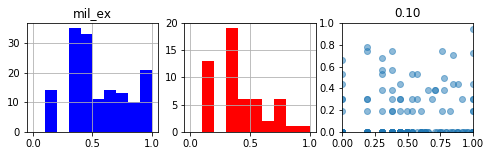

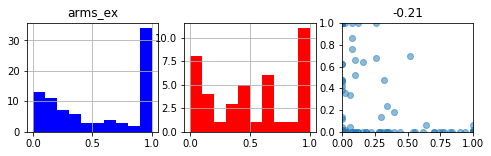

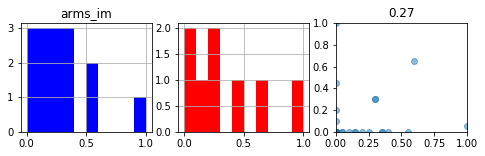

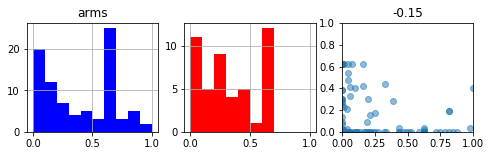

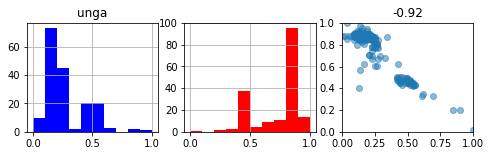

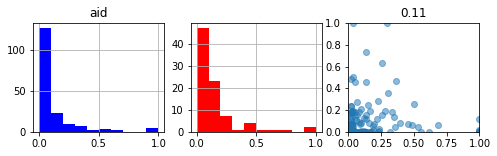

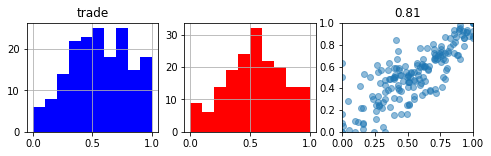

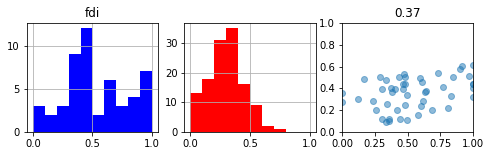

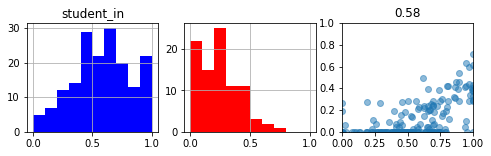

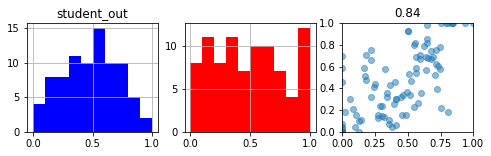

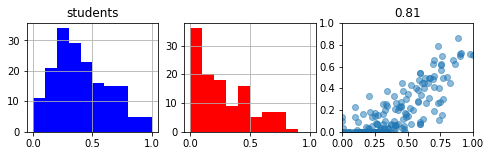

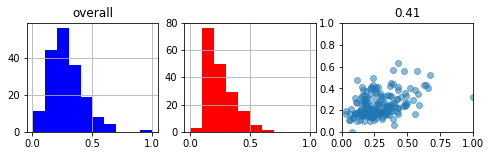

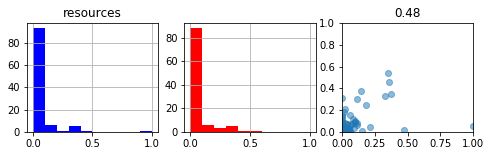

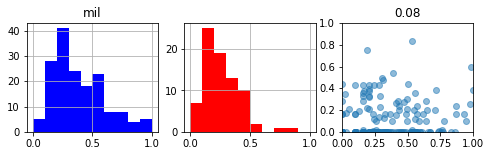

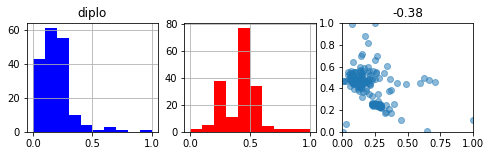

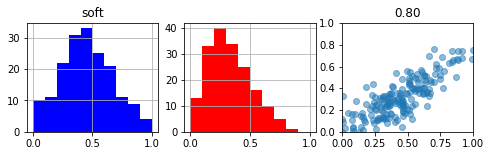

In [20]:
def plots(ind, *args, dat=dat, vmax=None, skipzeros=False):
    usi = '{}_us'.format(ind)
    cni = '{}_cn'.format(ind)
    if usi in dat:
        x = dat[usi].copy()
        y = dat[cni].copy()
        both = np.vstack((x,y))
        vmin = np.nanmin(both)
        if not vmax:
            vmax = np.nanmax(both)
        if skipzeros:
            x.loc[x==0] = np.nan
            y.loc[y==0] = np.nan
        fig, axs = plt.subplots(1, 3, figsize=(8, 2))
        x.hist(ax=axs[0], color='b', range=(vmin, vmax))
        y.hist(ax=axs[1], color='r', range=(vmin, vmax))
        axs[2].scatter(dat[usi], dat[cni], alpha=.5)
        axs[2].set_xlim((vmin, vmax))
        axs[2].set_ylim((vmin, vmax))
        axs[0].set_title(ind)
        axs[2].set_title("{:0.2f}".format(dat[[usi,cni]].corr().iloc[1,0]))
        fig.show()
iterind(plots, dat=out, vmax=1, skipzeros=True)

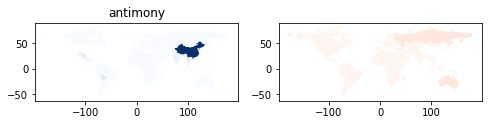

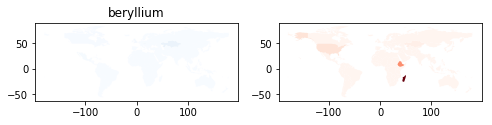

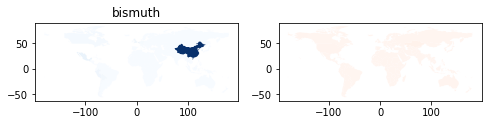

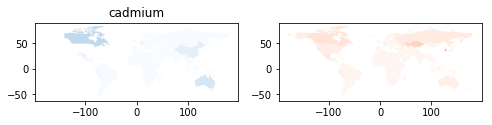

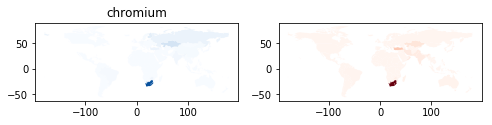

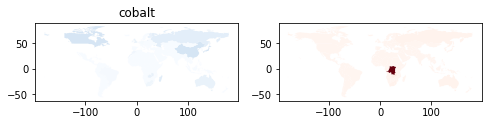

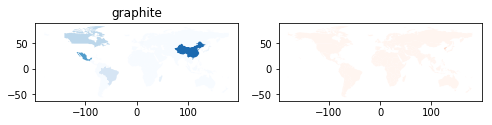

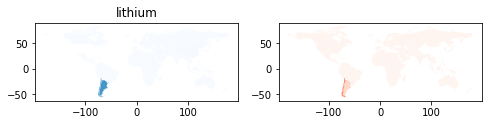

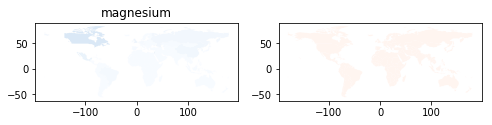

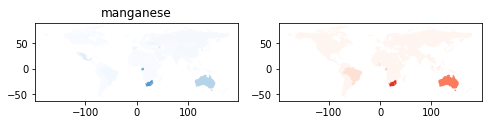

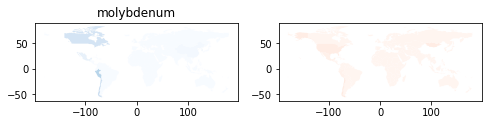

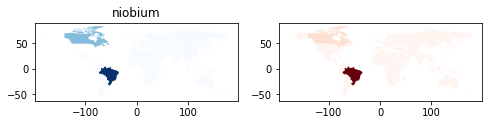

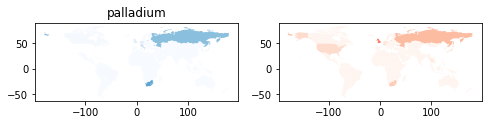

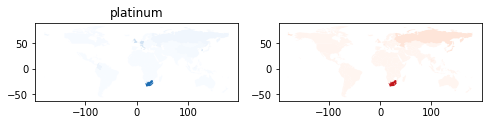

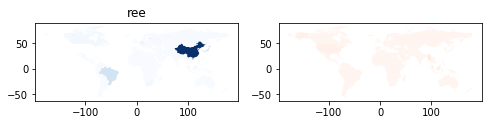

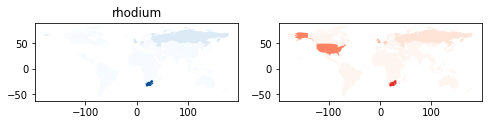

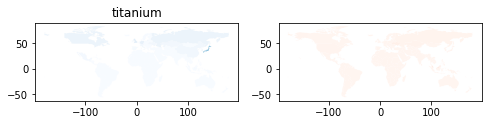

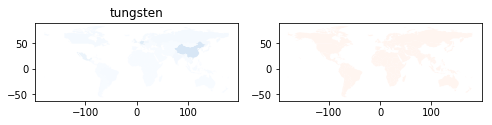

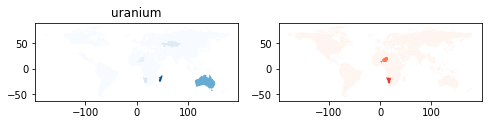

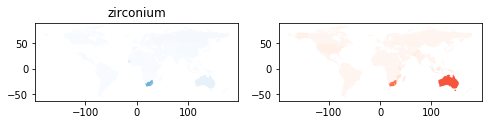

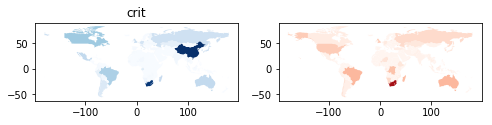

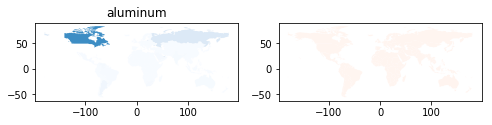

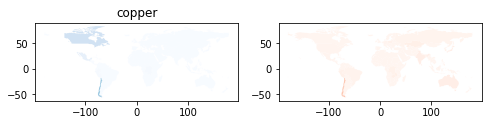

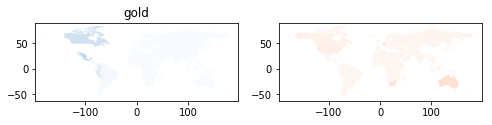

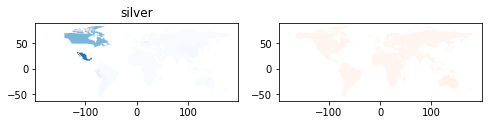

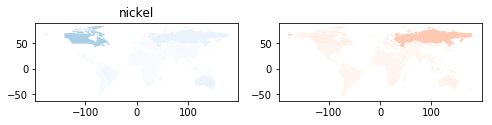

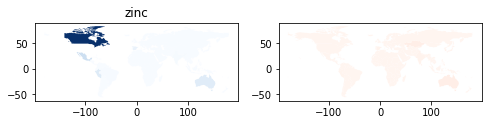

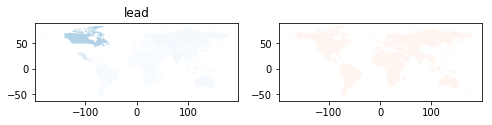

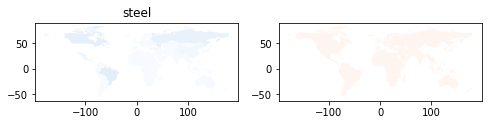

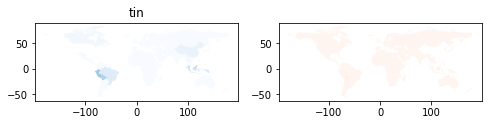

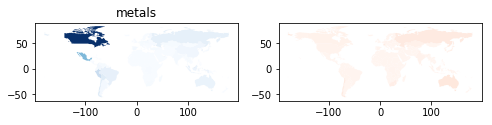

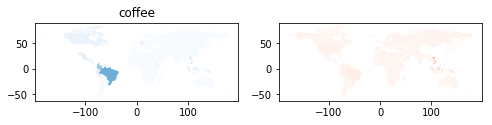

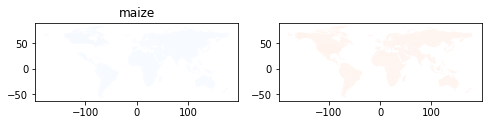

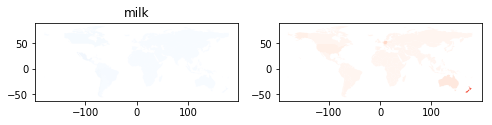

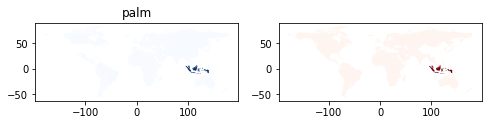

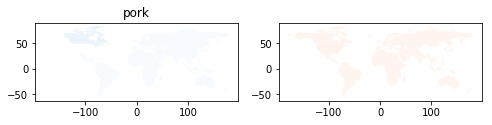

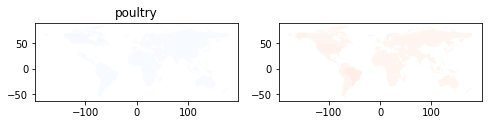

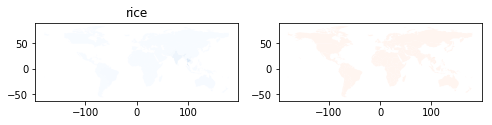

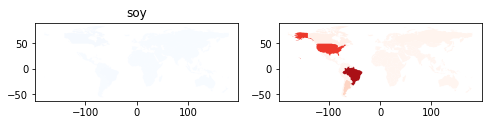

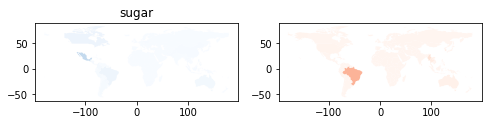

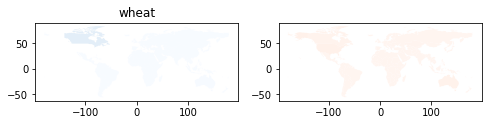

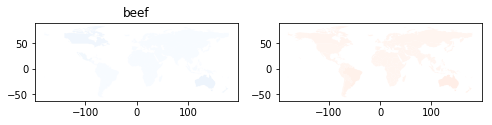

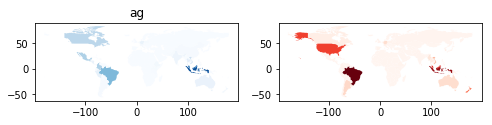

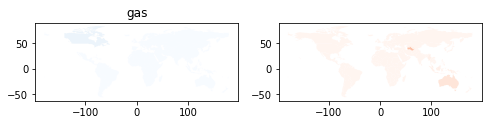

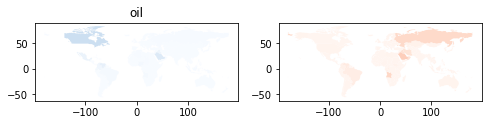

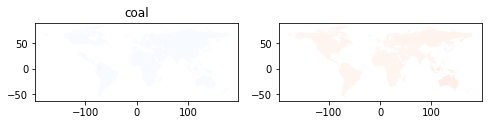

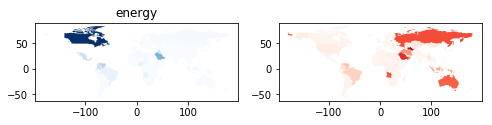

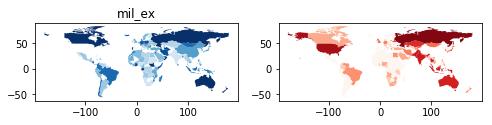

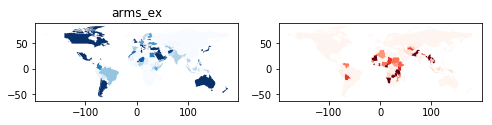

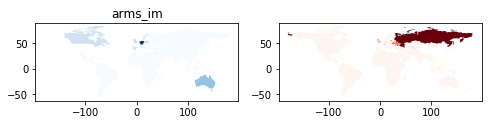

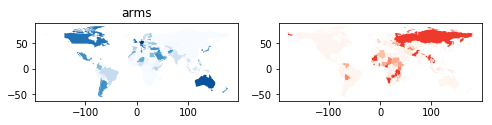

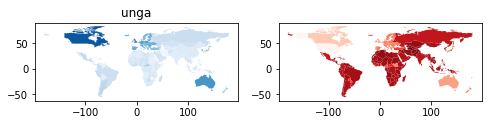

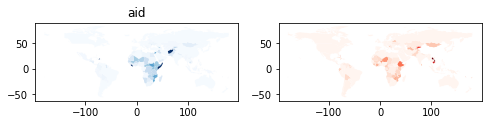

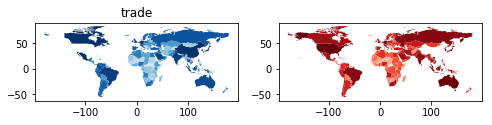

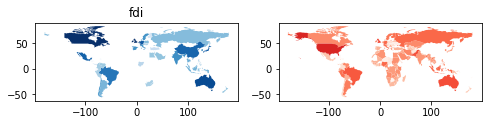

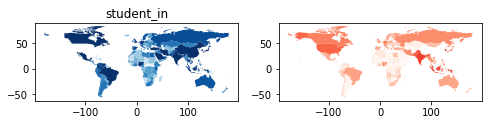

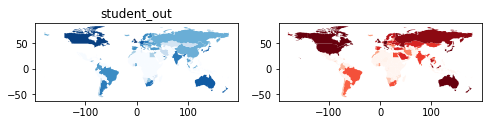

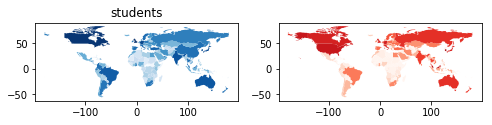

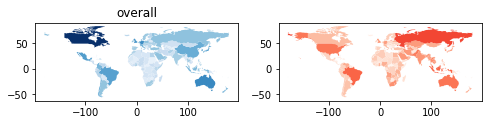

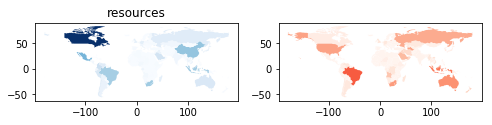

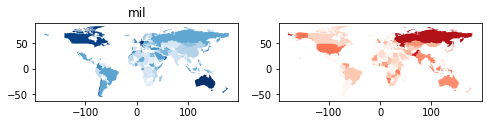

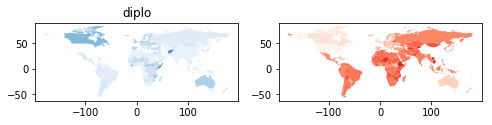

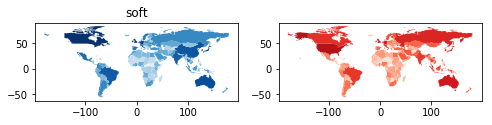

In [21]:
def maps(ind, *args, dat=dat, vmax=None):
    shp2 = shps.set_index('ISO_A3').join(dat)
    usi = '{}_us'.format(ind)
    cni = '{}_cn'.format(ind)
    if usi in dat:
        fig, axs = plt.subplots(1, 2, figsize=(8, 2))
        shp2[shp2[usi].notna()].plot(usi, ax=axs[0], cmap='Blues', vmax=vmax)
        shp2[shp2[cni].notna()].plot(cni, ax=axs[1], cmap='Reds', vmax=vmax)
        axs[0].set_title(ind)
        fig.show()
iterind(maps, dat=out, vmax=1)

In [22]:
def tops(ind, *args, dat=dat, n=10):
    usi = '{}_us'.format(ind)
    cni = '{}_cn'.format(ind)
    if usi in dat:
        print(ind)
        print(dat.set_index('country')[usi].sort_values(ascending=False).head(n))
        print(dat.set_index('country')[cni].sort_values(ascending=False).head(n))
        print('\n')
iterind(tops, dat=out)

antimony
country
China             1.000
Thailand          0.136
Bolivia           0.126
Belgium           0.122
Mexico            0.084
India             0.074
France            0.028
Peru              0.020
United Kingdom    0.020
Japan             0.018
Name: antimony_us, dtype: float64
country
Tajikistan    0.112
Russia        0.084
Australia     0.078
Kyrgyzstan    0.012
Myanmar       0.012
Thailand      0.012
Peru          0.006
Kazakhstan    0.006
Bolivia       0.006
Laos          0.006
Name: antimony_cn, dtype: float64


beryllium
country
Kazakhstan        0.060
Czech Republic    0.024
United Kingdom    0.022
Mexico            0.010
Philippines       0.006
Canada            0.004
Austria           0.004
France            0.002
Zimbabwe          0.000
Guinea            0.000
Name: beryllium_us, dtype: float64
country
Madagascar                        1.000
Ethiopia                          0.390
United States of America          0.102
Kazakhstan                        0.036
Zimb

country
South Korea                 1.000000
Japan                       1.000000
Germany                     1.000000
United States of America    1.000000
Australia                   0.982841
Malaysia                    0.953667
Vietnam                     0.948091
Russia                      0.932589
Brazil                      0.931886
Singapore                   0.926381
Name: trade_cn, dtype: float64


fdi
country
Ireland           1.000000
Canada            1.000000
United Kingdom    1.000000
Luxembourg        1.000000
Netherlands       1.000000
Singapore         0.967402
Switzerland       0.915411
Australia         0.895718
Germany           0.845349
Japan             0.830871
Name: fdi_us, dtype: float64
country
United States of America    0.701689
United Kingdom              0.612843
Switzerland                 0.605403
Australia                   0.575813
Pakistan                    0.568356
Brazil                      0.544648
Malaysia                    0.532644
Singapore  

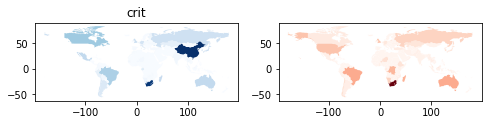

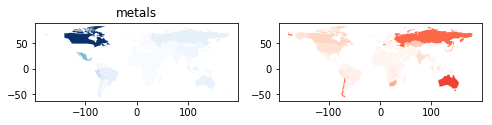

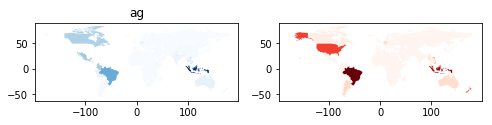

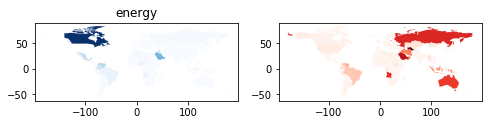

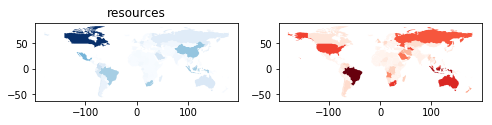

In [23]:
maps('crit', dat=out)
maps('crit', dat=out2)
maps('metals', dat=out)
maps('metals', dat=out2)
maps('ag', dat=out)
maps('ag', dat=out2)
maps('energy', dat=out)
maps('energy', dat=out2)
maps('resources', dat=out)
maps('resources', dat=out2)

In [24]:
out.to_csv('scored_values.csv')

resources
country
Canada          1.000000
Mexico          0.472097
China           0.395249
South Africa    0.370866
Indonesia       0.360317
Brazil          0.349674
Malaysia        0.330929
Colombia        0.212064
Saudi Arabia    0.180229
Peru            0.149616
Name: resources_us, dtype: float64
country
Brazil                      0.540594
Indonesia                   0.461941
Australia                   0.376668
South Africa                0.350323
Malaysia                    0.329456
United States of America    0.327470
Turkmenistan                0.313783
Russia                      0.299819
Saudi Arabia                0.250059
Angola                      0.211071
Name: resources_cn, dtype: float64




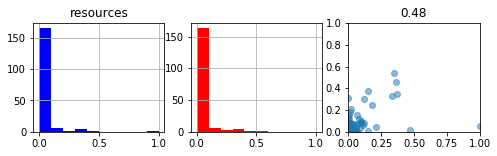

In [25]:
tops('resources', dat=out)
plots('resources', dat=out)


In [26]:
usi = 'mil_ex_us'
cni = 'mil_ex_cn'
np.nanpercentile(np.vstack((dat[usi], dat[cni])), 100-2.5)


38.0